### Coastal Fire Analysis & Data Exploration

This notebook investigates the spatial distribution and environmental characteristics of positive fire samples. Key steps include:

- **Coastal proximity analysis**: Using shapefiles of global coastlines, the Euclidean distance from each positive fire sample to the nearest coastline is computed. Samples are classified as *coastal* or *inland* based on a 100 km threshold, allowing for statistical comparison.
- **Exploratory mapping**: Fires are visualized using Cartopy, with color-coded markers based on environmental variables such as wind direction.
- **Temporal filtering**: A subset of positive samples from 2021 and 2022 is selected for further testing and visualization.
- **Missing data analysis**: The proportion of missing values in key temperature variables (`lst_day`, `lst_night`, and `t2m`) is compared between ignition dates (`time_idx == 0`) and non-ignition dates to identify possible data quality issues related to fire onset.

This workflow supports understanding how spatial and temporal patterns—especially coastal proximity and missing environmental data—relate to wildfire occurrence and model input reliability.


In [9]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [10]:
pos_data = pd.read_csv('./a.danger_forecasting/positives.csv')
neg_data = pd.read_csv('./a.danger_forecasting/negatives.csv')

In [12]:
print(len(pos_data))

257220


In [21]:
import geopandas as gpd
from shapely.geometry import Point
def get_coast_csv(data_description, csv):
    coastline = gpd.read_file("/Users/I566184/bachelorarbeit_coding/ne_110m_coastline/ne_110m_coastline.shp")

    # use the argument csv, not pos_data
    csv["geometry"] = csv.apply(lambda row: Point(row["x"], row["y"]), axis=1)
    fires_gdf = gpd.GeoDataFrame(csv, geometry="geometry", crs="EPSG:4326")

    coastline = coastline.to_crs("EPSG:3857")
    fires_gdf = fires_gdf.to_crs("EPSG:3857")

    # Minimal Distance to Coastline
    fires_gdf["dist_to_coast"] = fires_gdf.geometry.apply(
        lambda p: coastline.distance(p).min() / 1000
    )  # in km

    coastal_threshold = 100
    fires_gdf["coastal"] = fires_gdf["dist_to_coast"] < coastal_threshold

    coastal_df = fires_gdf[fires_gdf["coastal"]].copy()
    inland_df  = fires_gdf[~fires_gdf["coastal"]].copy()

    cols_no_geom = [c for c in fires_gdf.columns if c != "geometry"]

    coastal_df[cols_no_geom].to_csv(f"{data_description}_coastal.csv", index=False)
    inland_df[cols_no_geom].to_csv(f"{data_description}_inland.csv", index=False)

    print(len(coastal_df), "coastal samples written")
    print(len(inland_df), "inland samples written")

    summary = fires_gdf["coastal"].value_counts(normalize=True)
    print(f"Percentage of {data_description} fires close to the coast:", summary[True])
    print(f"Percentage of {data_description} inland fires:", summary[False])


In [22]:
get_coast_csv("positives", pos_data)

186510 coastal samples written
70710 inland samples written
Percentage of positives fires close to the coast: 0.725099136925589
Percentage of positives inland fires: 0.27490086307441103


In [23]:
get_coast_csv("negatives", neg_data)

258600 coastal samples written
261660 inland samples written
Percentage of negatives fires close to the coast: 0.49705916272632916
Percentage of negatives inland fires: 0.5029408372736709


In [24]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

def annotate_and_save_coastal(
        csv_path,
        coastline_shp,
        out_suffix="_coastal",
        threshold_km=100,
        keep_distance_column=False
):
    """
    Liest csv_path (erwartet Spalten 'x','y'), annotiert Spalte 'coastal' (0/1)
    anhand der Distanz zur Küstenlinie und speichert eine neue CSV im selben Ordner.
    Beispiel-Ausgabe: positives_binary_coastal.csv

    Args:
        csv_path (str | Path): Pfad zur Eingabe-CSV (z.B. positives.csv)
        coastline_shp (str | Path): Pfad zur Küsten-Shapefile (.shp)
        out_suffix (str): Suffix des Ausgabedateinamens (Default: "_coastal")
        threshold_km (float): Distanzschwelle in km für "coastal"
        keep_distance_column (bool): Wenn True, schreibe zusätzlich 'dist_to_coast_km'
    """
    csv_path = Path(csv_path)
    df = pd.read_csv(csv_path)

    # Geo-Daten vorbereiten
    gdf = gpd.GeoDataFrame(
        df.copy(),
        geometry=[Point(xy) for xy in zip(df["x"], df["y"])],
        crs="EPSG:4326"
    )

    # Einheit in Meter (Web Mercator), damit Distanzberechnung sinnvoll ist
    gdf = gdf.to_crs("EPSG:3857")

    coastline = gpd.read_file(coastline_shp)
    coastline = coastline.to_crs("EPSG:3857")

    # Geometrien zu einem Multi-Linestring vereinigen für schnelle Distanzberechnung
    coast_union = coastline.geometry.union_all()


    # Distanz (in Meter) -> km
    dist_km = gdf.geometry.distance(coast_union) / 1000.0
    gdf["coastal"] = (dist_km < threshold_km).astype(int)

    if keep_distance_column:
        gdf["dist_to_coast_km"] = dist_km

    # Ausgabe-Dateiname im selben Ordner, mit Suffix
    out_path = csv_path.with_name(csv_path.stem + out_suffix + csv_path.suffix)

    # Geometriespalte vor dem Speichern rausnehmen
    cols = [c for c in gdf.columns if c != "geometry"]
    gdf[cols].to_csv(out_path, index=False)

    # Kurzes Summary
    n_total = len(gdf)
    n_coastal = int(gdf["coastal"].sum())
    n_inland = n_total - n_coastal
    print(f"Wrote: {out_path}")
    print(f"Total: {n_total} | Coastal: {n_coastal} ({n_coastal/n_total:.1%}) | Inland: {n_inland} ({n_inland/n_total:.1%})")

    return out_path


In [25]:
coastline_shp = "/Users/I566184/bachelorarbeit_coding/ne_110m_coastline/ne_110m_coastline.shp"

annotate_and_save_coastal(
    "./a.danger_forecasting/positives.csv",
    coastline_shp=coastline_shp,
    out_suffix="_coastal",
    threshold_km=100,
)

annotate_and_save_coastal(
    "./a.danger_forecasting/negatives.csv",
    coastline_shp=coastline_shp,
    out_suffix="_coastal",
    threshold_km=100
)

Wrote: a.danger_forecasting/positives_coastal.csv
Total: 257220 | Coastal: 186510 (72.5%) | Inland: 70710 (27.5%)
Wrote: a.danger_forecasting/negatives_coastal.csv
Total: 520260 | Coastal: 258600 (49.7%) | Inland: 261660 (50.3%)


PosixPath('a.danger_forecasting/negatives_coastal.csv')

In [26]:
import pandas as pd
from pathlib import Path

# Dateien, die du gerade erzeugt hast
pos_path = Path("./a.danger_forecasting/positives_coastal.csv")
neg_path = Path("./a.danger_forecasting/negatives_coastal.csv")

# Positive Samples laden
pos_df = pd.read_csv(pos_path)
# Trennen in coastal vs inland
pos_coastal = pos_df[pos_df["coastal"] == 1]
pos_inland = pos_df[pos_df["coastal"] == 0]

# Negative Samples laden
neg_df = pd.read_csv(neg_path)
neg_coastal = neg_df[neg_df["coastal"] == 1]
neg_inland = neg_df[neg_df["coastal"] == 0]

print(len(pos_df), len(pos_coastal), len(pos_inland))
print(len(neg_df), len(neg_coastal), len(neg_inland))


# Speichern
#pos_coastal.to_csv("/Users/I566184/bachelorarbeit_coding/mesogeos/ml_tracks/a_fire_danger/a.danger_forecasting/positives_coastal_only.csv", index=False)
#pos_inland.to_csv("/Users/I566184/bachelorarbeit_coding/mesogeos/ml_tracks/a_fire_danger/a.danger_forecasting/positives_inland_only.csv", index=False)
#neg_coastal.to_csv("/Users/I566184/bachelorarbeit_coding/mesogeos/ml_tracks/a_fire_danger/a.danger_forecasting/negatives_coastal_only.csv", index=False)
#neg_inland.to_csv("/Users/I566184/bachelorarbeit_coding/mesogeos/ml_tracks/a_fire_danger/a.danger_forecasting/negatives_inland_only.csv", index=False)

257220 186510 70710
520260 258600 261660


In [17]:
neg_data[(neg_data['time_idx'] == 29) & (neg_data['sample'] == 15754)]

,time,aspect,burned_areas,curvature,d2m,dem,ignition_points,lai,lst_day,lst_night,...,lc_grassland,lc_settlement,lc_shrubland,lc_sparse_vegetation,lc_water_bodies,lc_wetland,population,burned_area_has,time_idx,sample
472649,2021-09-16,14.811633,0.0,-5010.8857,290.7063,248.38335,0.0,1.4,NaN,293.41998,...,0.0,0.03055,0.0,0.0,0.03073,0.0,774.1947,0.0,29,15754


In [20]:
sample_ids = [
    16608, 17285, 16028, 15754, 16217, 15344, 16648, 16618, 16099, 16241, 15160, 16087, 15028, 16201, 15865,
    15765, 15904, 16305, 17216, 14981, 16314, 16268, 16279, 16182, 15789, 14905, 15588, 14908, 16172, 14751,
    16353, 14821, 15796, 16549, 16877, 16370, 15438, 15888, 16527, 16137, 16599, 15187, 15004, 15186, 15488,
    14865, 16256, 15596, 16164, 15029, 15987, 16134, 16301, 16976, 16967, 15473, 17301, 14630, 14661, 16254,
    15629, 14940, 15299, 16360, 16073, 15157, 16051, 14965, 16436, 16402, 15689, 15684, 15923, 16517, 15001,
    14947, 15152, 17128, 14754, 16723, 15840, 16126, 17254, 14857, 16694, 16068, 16385, 15594, 15897, 16364,
    15755, 15084, 15925, 14814, 15154, 14848, 16281, 15202, 14985, 15704
]


neg_data[(neg_data['time_idx'] == 29) & (neg_data['sample'].isin(sample_ids))]


,time,aspect,burned_areas,curvature,d2m,dem,ignition_points,lai,lst_day,lst_night,...,lc_grassland,lc_settlement,lc_shrubland,lc_sparse_vegetation,lc_water_bodies,lc_wetland,population,burned_area_has,time_idx,sample
438929,2021-02-03,47.902977,0.0,9912.701000,281.15628,544.08234,0.0,0.4,NaN,NaN,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,12.044042,0.0,29,14630
439859,2021-02-26,348.523960,0.0,2953.784200,278.54214,998.03650,0.0,0.3,NaN,NaN,...,0.000000,0.0,0.649351,0.000000,0.0,0.0,1.778814,0.0,29,14661
442559,2021-03-16,116.038030,0.0,7618.783700,276.04822,557.56354,0.0,1.1,NaN,NaN,...,0.337703,0.0,0.000000,0.000000,0.0,0.0,64.983536,0.0,29,14751
442649,2021-03-17,27.835249,0.0,194.421390,272.03012,938.43317,0.0,1.6,291.30000,272.30000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,2.075181,0.0,29,14754
444449,2021-03-28,338.884900,0.0,-325.207520,268.01900,963.74133,0.0,0.2,302.82000,280.68000,...,0.000000,0.0,0.000000,0.136927,0.0,0.0,23.157936,0.0,29,14814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513869,2022-08-24,147.589300,0.0,-15664.542000,291.08994,400.64777,0.0,1.0,303.32000,290.62000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,259.879500,0.0,29,17128
516509,2022-09-08,15.938473,0.0,-25.238228,295.72168,36.69320,0.0,0.5,309.90000,294.46000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.025115,0.0,29,17216
517649,2022-09-14,60.346176,0.0,-17338.396000,290.79623,589.66320,0.0,1.4,NaN,287.47998,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,2.229254,0.0,29,17254
518579,2022-09-20,249.333370,0.0,12535.815000,283.86267,1746.79920,0.0,1.0,NaN,282.32000,...,0.000000,0.0,0.004407,0.000000,0.0,0.0,0.710323,0.0,29,17285


In [6]:
neg_data.columns

Index(['time', 'aspect', 'burned_areas', 'curvature', 'd2m', 'dem',
       'ignition_points', 'lai', 'lst_day', 'lst_night', 'ndvi', 'rh',
       'roads_distance', 'slope', 'smi', 'sp', 'ssrd', 't2m', 'tp',
       'wind_direction', 'wind_speed', 'x', 'y', 'lc_agriculture', 'lc_forest',
       'lc_grassland', 'lc_settlement', 'lc_shrubland', 'lc_sparse_vegetation',
       'lc_water_bodies', 'lc_wetland', 'population', 'burned_area_has',
       'time_idx', 'sample'],
      dtype='object')

In [17]:
neg_testing = neg_data[((neg_data['time'].str.startswith("2022-07-")) | (neg_data['time'].str.startswith("20e"))) & (neg_data['time_idx'] == 29)]
neg_testing.to_csv("neg_testing.csv", index=False)

In [18]:
pos_data[pos_data['sample'] == 1645]

,time,aspect,burned_areas,curvature,d2m,dem,ignition_points,lai,lst_day,lst_night,...,lc_grassland,lc_settlement,lc_shrubland,lc_sparse_vegetation,lc_water_bodies,lc_wetland,population,burned_area_has,time_idx,sample
49350,2022-05-17,36.664577,0.0,-11440.387,283.96823,949.5649,0.0,1.5,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,3.367628,28046.0,0,1645
49351,2022-05-18,36.664577,0.0,-11440.387,283.93564,949.5649,0.0,1.5,NaN,284.38000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.367628,28046.0,1,1645
49352,2022-05-19,36.664577,0.0,-11440.387,285.07065,949.5649,0.0,1.5,299.08000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,3.367628,28046.0,2,1645
49353,2022-05-20,36.664577,0.0,-11440.387,285.68314,949.5649,0.0,1.5,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,3.367628,28046.0,3,1645
49354,2022-05-21,36.664577,0.0,-11440.387,285.79310,949.5649,0.0,1.5,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,3.367628,28046.0,4,1645
49355,2022-05-22,36.664577,0.0,-11440.387,284.34592,949.5649,0.0,1.5,NaN,283.90000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.367628,28046.0,5,1645
49356,2022-05-23,36.664577,0.0,-11440.387,277.89755,949.5649,0.0,1.5,286.75998,278.32000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.367628,28046.0,6,1645
49357,2022-05-24,36.664577,0.0,-11440.387,277.82610,949.5649,0.0,1.5,286.10000,277.62000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.367628,28046.0,7,1645
49358,2022-05-25,36.664577,0.0,-11440.387,280.20220,949.5649,0.0,2.2,292.66000,282.02000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.367628,28046.0,8,1645
49359,2022-05-26,36.664577,0.0,-11440.387,281.22302,949.5649,0.0,2.2,297.38000,285.58000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.367628,28046.0,9,1645


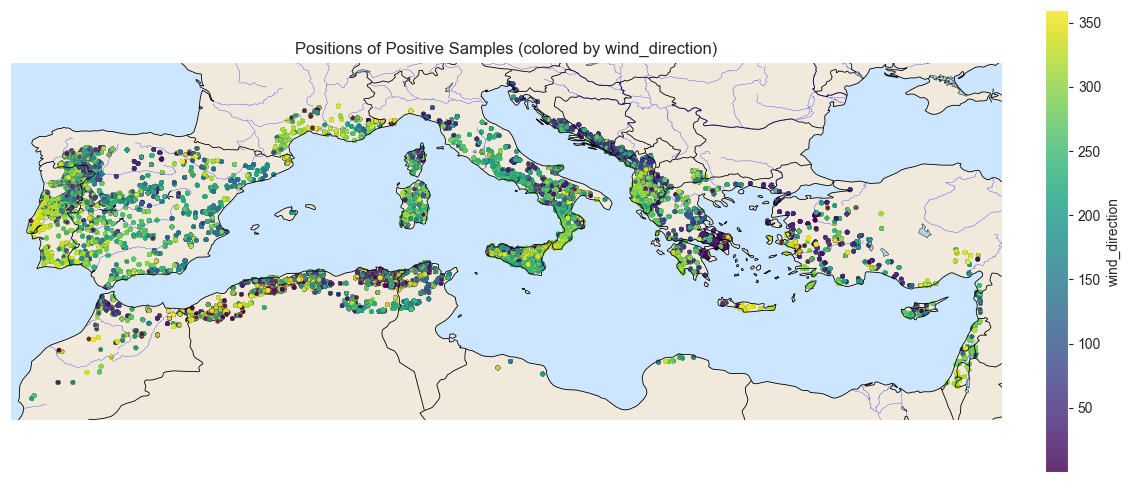

In [21]:
x = pos_data['x']
y = pos_data['y']
influence_variable = pos_data['wind_direction']

fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([x.min() - 1, x.max() + 1, y.min() - 1, y.max() + 1], crs=ccrs.PlateCarree())
#ax.stock_img()

ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#f0e9dc')  # Sandfarben
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='#cce6ff')  # Hellblau
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.6)
ax.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='lightblue', edgecolor='k', linewidth=0.3)
ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.2)

sc = ax.scatter(x, y, c=influence_variable, cmap='viridis', s=5, alpha=0.8, vmin=influence_variable.min(), vmax=influence_variable.max(), transform=ccrs.PlateCarree())

cb = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cb.set_label(f'{influence_variable.name}')

plt.title(f"Positions of Positive Samples (colored by {influence_variable.name})")

plt.show()

In [15]:
ignition_dates = pos_data[pos_data['time_idx'] == 0]
sum_ignition = ignition_dates['time'].count()
sum_ignition

8574

In [16]:
nan_counts_lst_day = ignition_dates['lst_day'].isna().sum()
nan_counts_lst_night = ignition_dates['lst_night'].isna().sum()
nan_counts_t2m = ignition_dates['t2m'].isna().sum()

In [17]:
non_ignition_dates = pos_data[pos_data['time_idx'] != 0]
sum_non_ignition = non_ignition_dates['time'].count()
sum_non_ignition

248646

In [47]:
nan_counts_lst_day_no = non_ignition_dates['lst_day'].isna().sum()
nan_counts_lst_night_no = non_ignition_dates['lst_night'].isna().sum()
nan_counts_t2m_no = non_ignition_dates['t2m'].isna().sum()

Vergleich der NaN-Werte in lst_day, lst_night und t2m zwischen den Zünddaten und den Nicht-Zünddaten

In [43]:
no_ignition_lst_day_percentage, no_ignition_lst_night_percentage, no_ignition_t2m_percentage = nan_counts_lst_day_no/sum_non_ignition, nan_counts_lst_night_no/sum_non_ignition, nan_counts_t2m_no/sum_non_ignition

In [50]:
ignition_lst_day_percentage, ignition_lst_night_percentage, ignition_t2m_percentage = nan_counts_lst_day/sum_ignition, nan_counts_lst_night/sum_ignition, nan_counts_t2m/sum_ignition
print ("Comparison of NaN values in lst_day, lst_night and t2m between ignition dates and non-ignition dates")
print (f"lst_day: {ignition_lst_day_percentage:.2%} vs {no_ignition_lst_day_percentage:.2%}")
print (f"lst_night: {ignition_lst_night_percentage:.2%} vs {no_ignition_lst_night_percentage:.2%}")
print (f"t2m: {ignition_t2m_percentage:.2%} vs {no_ignition_t2m_percentage:.2%}")

Comparison of NaN values in lst_day, lst_night and t2m between ignition dates and non-ignition dates
lst_day: 22.38% vs 19.09%
lst_night: 29.40% vs 25.19%
t2m: 0.00% vs 0.00%
